Num GPUs Available:  1


<ipython-input-2-c3e972652ad9>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.83333333 0.83333333 1.         ... 0.83333333 1.         1.        ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train_data.loc[:, features] = scaler.fit_transform(train_data[features])
<ipython-input-2-c3e972652ad9>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.63636364 0.63636364 0.63636364 ... 1.         1.         1.        ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  train_data.loc[:, features] = scaler.fit_transform(train_data[features])
<ipython-input-2-c3e972652ad9>:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         ... 0.83333333 1.         1.        ]

Epoch 1/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0046 - mae: 0.0387 - val_loss: 0.0036 - val_mae: 0.0330
Epoch 2/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0031 - mae: 0.0300 - val_loss: 0.0024 - val_mae: 0.0289
Epoch 3/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0023 - mae: 0.0262 - val_loss: 0.0017 - val_mae: 0.0253
Epoch 4/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0017 - mae: 0.0228 - val_loss: 0.0015 - val_mae: 0.0231
Epoch 5/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0016 - mae: 0.0215 - val_loss: 0.0012 - val_mae: 0.0210
Epoch 6/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0013 - mae: 0.0198 - val_loss: 0.0012 - val_mae: 0.0206
Epoch 7/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - mae: 0.0194 - val_loss: 0.0011 - val_mae: 0.0206
Epoch 8/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0012 - mae: 0.0187 - val_loss: 0.0011 - val_mae: 0.0203
Epoch 9/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step -

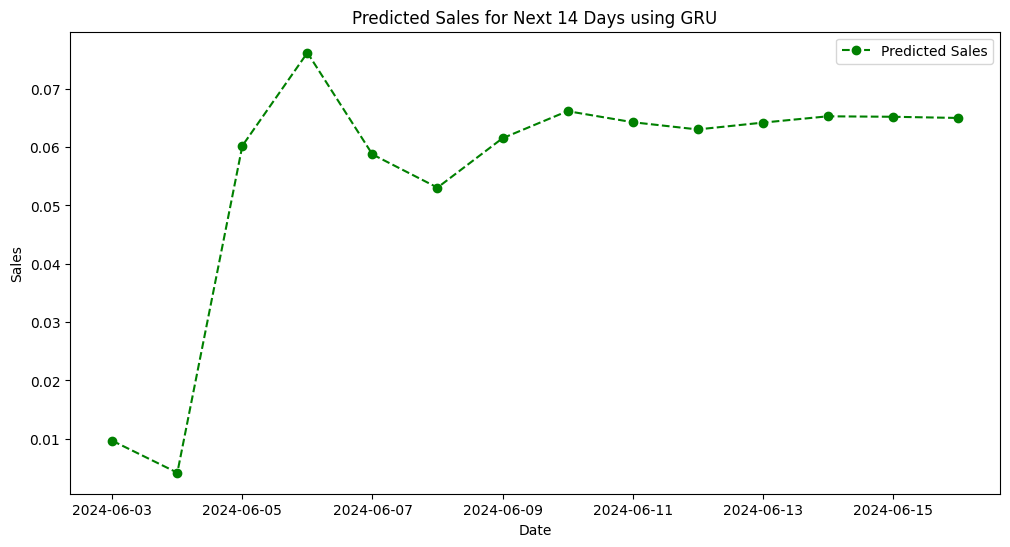

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Đọc dữ liệu
data = pd.read_csv("data_integrated.csv")

# Chuyển cột 'date' sang định dạng thời gian
data['date'] = pd.to_datetime(data['date'])

# Tạo các đặc trưng từ cột date
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data['weekofyear'] = data['date'].dt.isocalendar().week

# Sắp xếp dữ liệu theo warehouse và thời gian
data = data.sort_values(by=['warehouse', 'date'])

# Tạo Lag Features và Rolling Mean cho mỗi kho hàng
def create_lag_features(df, lag_days=[7, 14], rolling_days=[7]):
    for lag in lag_days:
        df[f'sales_lag_{lag}'] = df.groupby('warehouse')['sales'].shift(lag)
    for roll in rolling_days:
        df[f'sales_roll_mean_{roll}'] = df.groupby('warehouse')['sales'].shift(1).rolling(roll).mean()
    return df

data = create_lag_features(data)
data = data.dropna()

# Mã hóa các cột dạng chuỗi
label_encoder = LabelEncoder()
for col in ['warehouse', 'category', 'holiday_name']:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Chia dữ liệu
train_end_date = '2023-12-31'
train_data = data[data['date'] <= train_end_date]
test_data = data[data['date'] > train_end_date]

# Chỉ giữ lại các cột cần thiết
features = ['sales', 'sales_lag_7', 'sales_lag_14', 'sales_roll_mean_7',
            'availability', 'max_discount', 'sell_price_main', 'weekday',
            'holiday', 'winter_school_holidays', 'school_holidays', 'month']
scaler = MinMaxScaler()

train_data.loc[:, features] = scaler.fit_transform(train_data[features])
test_data.loc[:, features] = scaler.transform(test_data[features])

# Chuẩn bị dữ liệu cho GRU
def prepare_sequences(data, features, target, seq_length=14):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[features].iloc[i:i+seq_length].values)
        y.append(data[target].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 14
X_train, y_train = prepare_sequences(train_data, features, 'sales', seq_length)
X_test, y_test = prepare_sequences(test_data, features, 'sales', seq_length)

with tf.device('/GPU:0'):
    # Xây dựng mô hình GRU
    model = Sequential([
        GRU(64, activation='relu', return_sequences=True, input_shape=(seq_length, len(features))),
        GRU(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

    # Huấn luyện mô hình
    history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test), verbose=1)

# Đánh giá mô hình
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"MAE: {mae}")

# Dự đoán 14 ngày tiếp theo
future_inputs = test_data[features].iloc[-seq_length:].values
future_predictions = []

for _ in range(14):
    future_inputs_scaled = future_inputs.reshape(1, seq_length, len(features))
    pred = model.predict(future_inputs_scaled)[0, 0]
    future_predictions.append(pred)
    future_inputs = np.vstack([future_inputs[1:], np.hstack([pred, future_inputs[-1, 1:]])])

# Hiển thị kết quả dự báo
future_dates = pd.date_range(test_data['date'].max() + pd.Timedelta(days=1), periods=14)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, marker='o', linestyle='--', color='green', label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Predicted Sales for Next 14 Days using GRU')
plt.legend()
plt.show()


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


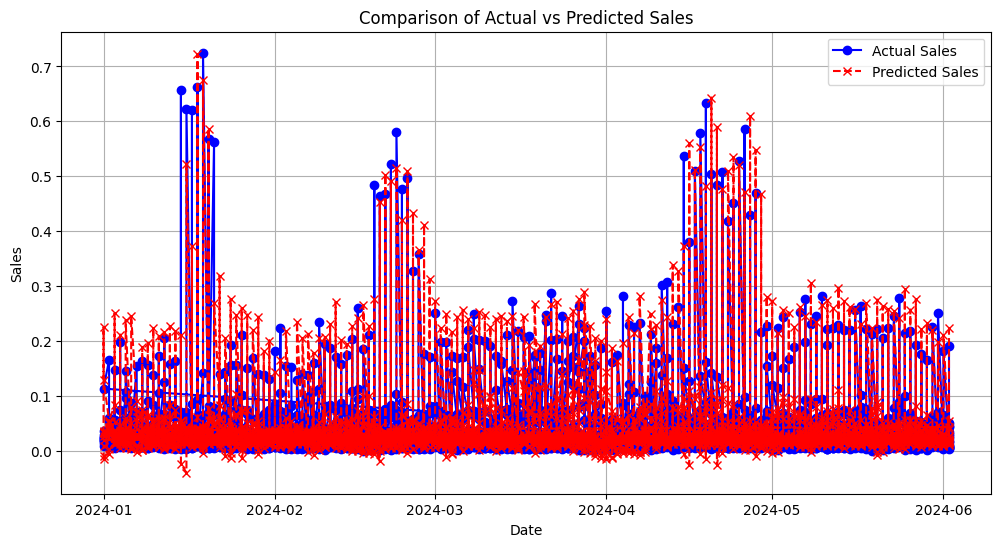

In [ ]:
# Vẽ biểu đồ so sánh kết quả dự báo
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test_xgb , label='Actual Sales', color='blue')
plt.plot(test_data['date'], y_pred_xgb , label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.show()
